# Contextualized embedding with transformer models illustrated

In this notebook, we begin to peek under the hood of a BERT transformer model to understand how contextualized embedding work.
We then also introduce a couple of potential use cases that leverage contextualized embeddings.

<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/dev/notebooks/contextualized_embedding_transformers_explained.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Setup

In [1]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    !pip install -q transformers==4.44.1 matplotlib==3.9.2 umap-learn==0.5.6 bertviz==1.4.0

if COLAB:
    data_path = 'https://raw.githubusercontent.com/haukelicht/advanced_text_analysis/refs/heads/dev/data/misc/'
else:
    import os
    data_path = os.path.join('..', 'data', 'misc', '')

## Intro to the `transformers` library

In python, the standard library to work with transformer models is `transformers`.
It provides access to pre-trained transformers models through its [model hub]().
The `transformers` library is developed and maintained by Hugging Face Inc.

### pre-trained models and tokenizers

To use a pre-trained model for embedding texts, we need two things:

1. the model's tokenizer
1. and of course the model itself

We use the model to process a text though its **layers** to obtain the text's **embedding**.
But to be able to do this, we need to **tokenize** the text to convert it into number – because deep neural network can only process with numbers, not with raw text.

Below we load a pre-trained BERT model, specifically "bert-base-uncased", which is a smallish version of BERT (hence 'base' instead of 'large') that does not distinguish between upper- and lowercase letters (hence 'uncased'). 

In [2]:
from transformers import BertTokenizer, BertModel

# define the name of the model we want to load
MODEL_NAME = 'bert-base-uncased'
# load the pre-trained model and tokenizer 
model = BertModel.from_pretrained(MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
# note: this will trigger downloading the model and tokenizer if you haven't done so before

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's get some information about the model by looking at its configuration attribute (`config`):

In [3]:
# let's get some important information about the model
print('embedding dimensionality:', model.config.hidden_size)
print('number of layers:', model.config.num_hidden_layers)
print('vocabulary size:', model.config.vocab_size)

embedding dimensionality: 768
number of layers: 12
vocabulary size: 30522


## Contextualized embedding

To illustrate how contextualized embedding works in transformers, we will first look at how embeddings of the same word differ if their context differs.

Let's take two sentences what contain the word "bank" but use it with different meanings:

In [4]:
sentences = [
    "Today, I will hike along the bank of a river.",
    "Today, I will open a new account at my bank and deposit some money.",
] 

To get the transformer embedding of the word "bank" in these two sentences, we need to follow three steps:

1. tokenizer thge texts and convert tokens into tokens IDs (to look-up their input embeddings)
2. process these inputs through the model
3. locate the embedding of the focal word in the two sentences.

#### 1) tokenize

In [5]:
inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True)

In [6]:
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]',
 'today',
 ',',
 'i',
 'will',
 'hike',
 'along',
 'the',
 'bank',
 'of',
 'a',
 'river',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [7]:
focal_word_id = tokenizer.convert_tokens_to_ids('bank')
focal_word_id

2924

In [8]:
# create maks that is true where input ID == focal word ID
mask = inputs['input_ids'] == focal_word_id
mask

tensor([[False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False]])

#### 2) embed (process through model)

In [9]:
# get the intial emebdding of the focal word ("bank")
model.embeddings.word_embeddings.weight[focal_word_id].shape

torch.Size([768])

In [10]:
import torch
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

**_Note:_** We use `torch.no_grad()` to disable gradient tracking, which is used for "back propagation" – the method used to optimize deep neural networks' parameters  

In [11]:
print(type(outputs))
# list the object's attributes
list(outputs.__dict__.keys())

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>


['last_hidden_state',
 'pooler_output',
 'hidden_states',
 'past_key_values',
 'attentions',
 'cross_attentions']

In [12]:
# hiden states are the embeddings after each layer
len(outputs.hidden_states)

13

In [13]:
# the final embedding can be accessed like this: 
outputs.hidden_states[-1]

tensor([[[ 6.9635e-02, -1.3670e-01,  1.8761e-02,  ..., -3.3191e-01,
           2.8223e-01,  4.0468e-01],
         [ 1.1473e-01,  2.0836e-01,  2.0759e-01,  ..., -4.0463e-01,
           5.2734e-01,  3.1694e-04],
         [ 4.7067e-01,  3.2301e-01, -3.7870e-02,  ..., -2.0411e-01,
          -6.0445e-01, -2.8152e-01],
         ...,
         [ 2.7512e-01, -7.2288e-02,  3.4769e-01,  ...,  1.5942e-01,
           1.9152e-01,  2.0592e-02],
         [ 5.4426e-01,  1.9531e-02,  4.5647e-01,  ...,  3.7937e-02,
           6.0456e-02,  2.9131e-02],
         [-1.1070e-01, -3.1039e-01,  3.8267e-01,  ...,  3.2052e-01,
           9.5210e-02, -2.0710e-01]],

        [[ 3.0478e-01,  2.6739e-01,  2.5309e-01,  ...,  2.7564e-02,
           2.0101e-01,  4.0347e-01],
         [ 2.9554e-01,  6.8319e-02,  6.0473e-02,  ..., -6.9329e-02,
           6.2583e-01, -7.1609e-02],
         [ 4.1000e-01,  3.3869e-01,  2.9582e-01,  ..., -3.0349e-01,
          -7.9921e-01, -1.9085e-01],
         ...,
         [ 4.7458e-01, -3

In [14]:
# let'S look at the shape:
outputs.hidden_states[-1].shape

torch.Size([2, 18, 768])

#### 3) get the words' contextualized embeddings 

In [15]:
# final transformer embeddings of bank in different contexts
embeddings = outputs.last_hidden_state[mask]

In [16]:
# compute cosine similarity between the two embeddings
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))

array([[0.49588156]], dtype=float32)

Below you can see that the similarity of "bank"'s transformer embedding deepends on the model layer we look at.

In [17]:
# iterate over all layers
for i, layer in enumerate(outputs.hidden_states):
    # skip input embeddings
    if i == 0:
        continue
    embeddings = layer[mask]
    similarity = cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))
    print(f'layer {i}: {similarity}')

layer 1: [[0.69466114]]
layer 2: [[0.6006136]]
layer 3: [[0.51213026]]
layer 4: [[0.4832083]]
layer 5: [[0.4523459]]
layer 6: [[0.45166492]]
layer 7: [[0.4399917]]
layer 8: [[0.4065468]]
layer 9: [[0.40396655]]
layer 10: [[0.45446885]]
layer 11: [[0.49633488]]
layer 12: [[0.49588156]]


### 🔥 Exercise 🔥

**Try it your self!** 
Define a pair of sentences that use a word with different meanings.

*Bonus:* Can you think of a word from your  research domain or area of interest that has multiple meanins. If so, does BERT seem to distinguish these meanings?

## Attention &mdash; peeking under the hood

Let's use the amazing `bertviz` library to have a deeper look into the workings of transformers.
Let's define 

In [18]:
sentence = "Today, I will hike along the bank of a river."

### Head View

<b>The head view visualizes attention in one or more heads from a single Transformer layer.</b> Each line shows the attention from one token (left) to another (right). Line weight reflects the attention value (ranges from 0 to 1), while line color identifies the attention head. When multiple heads are selected (indicated by the colored tiles at the top), the corresponding  visualizations are overlaid onto one another.  For a more detailed explanation of attention in Transformer models, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

In [19]:
from bertviz import head_view
# from transformers import RobertaTokenizer, RobertaModel

# load the model
# model_version = 'roberta-base'
model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# retrieve attention weights
inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [21]:
# visualize
head_view(attention, tokens)

<IPython.core.display.Javascript object>

#### *Usage*

- **Hover** over any **token** on the left/right side of the visualization to filter attention from/to that token. <br/>
- **Double-click** on any of the **colored tiles** at the top to filter to the corresponding attention head.<br/>
- **Single-click** on any of the **colored tiles** to toggle selection of the corresponding attention head. <br/>
- **Click** on the **Layer** drop-down to change the model layer (zero-indexed).

### Neuron View
<b>The neuron view visualizes the intermediate representations (e.g. query and key vectors) that are used to compute attention.</b> In the collapsed view (initial state), the lines show the attention from each token (left) to every other token (right). In the expanded view, the tool traces the chain of computations that produce these attention weights. For a detailed explanation of the attention mechanism, please refer to the [blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

In [22]:
from bertviz.transformers_neuron_view import BertModel, BertTokenizer
from bertviz.neuron_view import show

bertviz_model = BertModel.from_pretrained(MODEL_NAME, output_attentions=True)
bertviz_tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
show(bertviz_model, 'bert', bertviz_tokenizer, sentence, layer=4, head=3)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/bertviz/transformers_neuron_view/modeling_utils.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### *Usage*

- **Hover** over any of the tokens on the left side of the visualization to filter attention from that token.<br/>
- Then **click** on the **plus** icon that is revealed when hovering. This exposes the query vectors, key vectors, and other intermediate representations used to compute the attention weights. Each color band represents a single neuron value, where color intensity indicates the magnitude and hue the sign (blue=positive, orange=negative).<br/>
- Once in the expanded view, **hover** over any other **token** on the left to see the associated attention computations.<br/>
- **Click** on the **Layer** or **Head** drop-downs to change the model layer or head (zero-indexed).

## Predicting masked-out words

In [23]:
from transformers import BertForMaskedLM
import torch

# Load the pre-trained model for masked language modeling
model = BertForMaskedLM.from_pretrained(MODEL_NAME)

# Define the text with a masked token
text = "He was walking along the [MASK] of the river."

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Get the index of the masked token
masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

# Predict the masked token
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
predictions[0, masked_index].shape

torch.Size([30522])

In [25]:
# Get the log probabilities of the 10 best fitting words
log_probs = torch.log_softmax(predictions[0, masked_index], dim=-1)
top_10_log_probs, top_10_indices = torch.topk(log_probs, 10)

# Convert indices to tokens
top_10_tokens = tokenizer.convert_ids_to_tokens(top_10_indices.tolist())

# Print the results
for token, log_prob in zip(top_10_tokens, top_10_log_probs):
    print(f"{token}: {log_prob.item()}")

bank: -0.5406798124313354
banks: -1.7048195600509644
edge: -2.184450149536133
side: -3.1157588958740234
shore: -4.044376373291016
bottom: -5.377610206604004
bed: -5.688791275024414
surface: -5.815121650695801
shores: -5.824519157409668
##bank: -5.886752128601074


## Example applications

### Using mask prediction to study model bias

In [26]:
import pandas as pd
from transformers import BertForMaskedLM, BertTokenizer

# Load the pre-trained model for masked language modeling
model = BertForMaskedLM.from_pretrained(MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def get_topk_words(text):
    
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt")

    # Get the index of the masked token
    masked_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

    # Predict the masked token
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits

    # Get the log probabilities of the 10 best fitting words
    log_probs = torch.log_softmax(predictions[0, masked_index], dim=-1)
    top_10_log_probs, top_10_indices = torch.topk(log_probs, 10)

    # Convert indices to tokens
    top_10_tokens = tokenizer.convert_ids_to_tokens(top_10_indices.tolist())

    # Print the results
    return pd.DataFrame({'token': top_10_tokens, 'log_prob': top_10_log_probs})

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to

In [27]:
get_topk_words('He was very [MASK].')

token  log_prob
0       good -3.055781
1      quiet -3.167320
2  beautiful -3.588074
3    serious -3.673759
4   handsome -3.794045
5      happy -3.836727
6     strong -3.843158
7       calm -4.042284
8      young -4.057733
9      angry -4.095256

In [28]:
get_topk_words('She was very [MASK].')

token  log_prob
0  beautiful -2.502169
1      quiet -3.159203
2     pretty -3.184892
3       good -3.568262
4      young -3.631835
5      happy -3.723594
6      tired -3.917143
7     strong -3.982161
8       calm -4.088913
9    serious -4.262284

### Using BERT for word sense disambiguation

**Question:** How can we use transformers to categorize in what sense a word is used in its context?

**_Idea:_**

1. a words' context clarifies its meaning
2. contextualized embeddings capture this by shifting embeddings to their context
3. this means that contextualized embeddings of a word different senses occupy different "locations" in the embedding space
4. given that the embeddings are high-dimensional numeric vectors, we can cluster them to disambiguate senses.


#### Implementation

I have asked OpenAI's GPT-4o to generate a list of sentences that use the word "bank" in different senses.
Below, we'll use this data to see how well BERT's ability to generate contextualized embeddings allows us to disambiguate between this word's contextual meanings.

In [35]:
from transformers import BertModel, BertTokenizer

# Load the pre-trained model for masked language modeling
model = BertModel.from_pretrained(MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
import os
import pandas as pd

# load the file
fp = data_path+'bank_sentences_with_senses.csv'
df = pd.read_csv(fp)

In [37]:
# check that all sentences contain the word "bank"
df.text.str.contains('bank').value_counts()

text
True    56
Name: count, dtype: int64

In [39]:
# tokenizer the sentences
inputs = tokenizer(df.text.to_list(), return_tensors="pt", padding=True, truncation=True)

In [40]:
# create maks that is true where input ID == focal word ID
mask = inputs['input_ids'] == focal_word_id

In [41]:
# process the inputs through the model
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

In [42]:
# Apply the mask to the last hidden layer output to get the focal words embeddings
focal_word_embeddings = outputs.last_hidden_state[mask]

In [43]:
# now we have the 768-dimensional embeddings of the focal word "bank" in each sentence
focal_word_embeddings.shape

torch.Size([56, 768])

**Questions:** How can we *see* whether or not and, if so, how the embeddings of words used in similar senses occupy similar locations in the embedding space?

**Answer:** dimensionality reduction

In [44]:
import umap
import matplotlib.pyplot as plt

# Reduce the embeddings to 2D
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(focal_word_embeddings)

/Users/hlicht/miniforge3/envs/advanced_text_analysis_gesis_2024/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


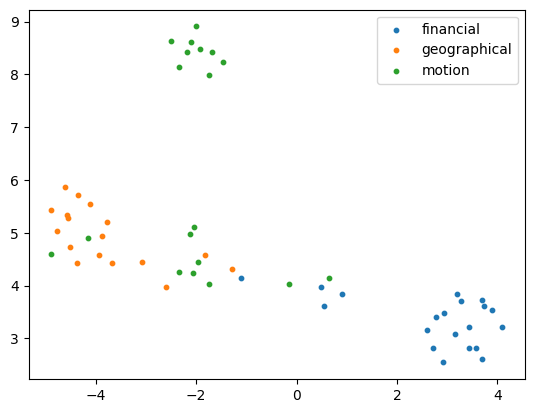

In [45]:
# plot the 2D embeddings by sense, using different colors and a legend indicating the sense
for sense in df.sense.unique():
    idxs = df.sense == sense
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=sense, s=10)
plt.legend()
plt.show()

Now, we eyeballed the data to find clusters.

**Question:** (How reliably) Can we automate this disambiguation approach?

In [46]:
# cluster in 2D using k-means with k=3
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(focal_word_embeddings)

In [47]:
# get category indicator of the sense
# cross tabulate the cluster labels with the sense labels
pd.crosstab(df.cluster, df.sense)

sense    financial  geographical  motion
cluster                                 
0                1            17       9
1                1             0      10
2               18             0       0

In [48]:
# use majority to label induced clusters
cluster_to_sense = {0: 'geographical', 1: 'motion', 2: 'financial'}
df['cluster_label'] = df.cluster.map(cluster_to_sense)

In [49]:
from sklearn.metrics import accuracy_score

# compute the accuracy of the clustering
accuracy_score(df.sense, df.cluster_label)

0.8035714285714286

In [50]:
# get examples where cluster label disagrees with label
for row in df[df.sense != df.cluster_label].itertuples():
    print(f'in cluster \'{row.cluster_label}\' instead of \'{row.sense}\': "{row.text}"')

in cluster 'motion' instead of 'financial': "He banked his hopes on getting the promotion at work."
in cluster 'geographical' instead of 'financial': "The bank of computers processed the data quickly."
in cluster 'geographical' instead of 'motion': "The car skidded off the road and into the bank of snow."
in cluster 'geographical' instead of 'motion': "The hikers reached the top of the hill and saw a bank of fog below."
in cluster 'geographical' instead of 'motion': "The bank of dirt blocked the road after the landslide."
in cluster 'geographical' instead of 'motion': "The thick bank of snow made it difficult to drive through the mountain pass."
in cluster 'geographical' instead of 'motion': "The wind pushed the boat closer to the bank of the river."
in cluster 'geographical' instead of 'motion': "The fog bank rolled in, obscuring the view of the ocean."
in cluster 'geographical' instead of 'motion': "The fog bank moved in quickly, covering the entire valley."
in cluster 'geographical'